# Libraries and data importing

Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import acf, pacf

In [3]:
from sklearn.metrics import r2_score, mean_absolute_error

Importing data

In [4]:
activities = pd.read_parquet('../data-raw/activities.parquet')
activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,analysis-bot,bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,neos-bot,bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


600 events for each contributor

In [5]:
data = ( 
    activities
    # keep the last 600 events for each contributor
    .groupby('contributor')
    .tail(600)
    # keep the contributors who have 600 events
    .groupby('contributor')
    .filter(lambda x: len(x) == 600)
)
data

,contributor,category,repository,activity,date
365,nodebb-misty,bot,julianlam/nodebb-plugin-email-helper,Closing pull request,2022-11-25 11:08:46+00:00
409,nodebb-misty,bot,NodeBB/nodebb-plugin-topic-redirect,Closing pull request,2022-11-25 11:20:10+00:00
417,nodebb-misty,bot,NodeBB/nodebb-plugin-write-api,Closing pull request,2022-11-25 11:21:23+00:00
523,nodebb-misty,bot,julianlam/nodebb-plugin-sso-oauth,Closing pull request,2022-11-25 11:47:30+00:00
5518,jenkins-x-bot-test,bot,jenkins-x-charts/jxboot-helmfile-resources,Creating branch,2022-11-26 19:57:10+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


# Evaluation metrics

In [6]:
def pga_score(y_true, y_pred):
    return (y_pred >= y_true).mean()

In [7]:
def ctd_score(y_true, y_pred, target_value):

    true_cumsum, pred_cumsum = np.cumsum(y_true), np.cumsum(y_pred)
    time_true, time_pred = np.argmax(true_cumsum >= target_value), np.argmax(pred_cumsum >= target_value)

    # display(true_cumsum.tolist(), pred_cumsum.tolist())

    if sum(y_true) < target_value:
        ctd = len(y_pred) - time_pred
    elif sum(y_pred) < target_value:
        ctd = time_true - len(y_true)
    else:
        ctd = time_true - time_pred

    return ctd

In [ ]:
true_values = [2, 11, 84, 57, 0, 38, 15, 80, 4, 30, 90, 0, 0, 500]
pred_values = [52, 22, 95, 9, 11, 1, 73, 0, 30, 50, 2, 1, 3, 0]

print("Cumulative Time Difference:", ctd_score(true_values, pred_values, 900))

# Time ranges

In [9]:
time_ranges = (
    data
    .groupby(['category', 'contributor'])['date']
    .agg(lambda x: int((x.iat[-1] - x.iat[0]).total_seconds()/3600))
    .reset_index(name='duration')
)
time_ranges.sort_values(by='duration')

,category,contributor,duration
77,bot,lgtm-com[bot],36
30,bot,codeclimate[bot],48
7,bot,adobe-bot,55
115,bot,renovate-approve-2[bot],61
105,bot,openshift-cherrypick-robot,64
...,...,...,...
135,bot,sre-bot,3237
219,human,748599,3278
157,human,353444,3287
69,bot,jenkins-x-bot-test,3340


<Axes: ylabel='duration'>

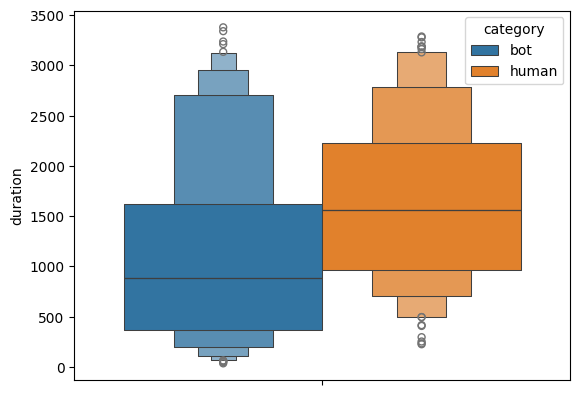

In [10]:
sns.boxenplot(time_ranges, y='duration', hue='category')

Maps a range duration (in seconds) to frequency format.

In [252]:
def range_to_frequency(contributor):
    
    train = contributor.head(300)
    train = train[train['date'] >= train['date'].max() - pd.DateOffset(months=3)]
    range = int((train['date'].iloc[-1] - train['date'].iloc[0]).total_seconds())
    range_m = range//3600//len(train)

    print('range :', range)
    print('range_m :', range_m)

    range = 3600

    if range_m == 0:    # one activity in less than an hour
        print("one activity in less than an hour")
        freq = range//3600
        print(freq, 'minutes')
    elif range_m == 1:  # one activity per hour
        print("one activity per hour")
        freq = 1
        print(freq, 'hour')
    else:               # one activity in more than an hour
        print("one activity in more than an hour")
        freq = 24//((24//range_m)+1)
        print(freq, 'hours')

In [276]:
# Example usage:
random_name = data['contributor'].sample().values[0]
print(random_name)

random_user = data[data['contributor'] == random_name]
range_to_frequency(random_user)

flinkbot
range : 542838
range_m : 0
one activity in less than an hour
1 minutes


# Data splitting

In [ ]:
def split_activities(contributor):

    frequency = range_to_frequency(contributor)

    result = (
        contributor
        .groupby([pd.Grouper(key='date', freq=frequency)])['activity']
        .count()
        .reset_index(name='n_activities')
        .set_index('date')
        .resample(frequency)
        .sum()
        .rename_axis(None)
        .assign(
            cumsum_activities = lambda x: x['n_activities'].cumsum()
        )
    )

    train, test = (
        result[result['cumsum_activities'] <= 300]
        .apply(lambda x : x[x.index >= x.index.max() - pd.DateOffset(months=3)])
        .drop('cumsum_activities', axis=1),

        result[result['cumsum_activities'] > 300]
        .drop('cumsum_activities', axis=1)
    )

    return train, test

In [ ]:
train, _ = split_activities(data[data['contributor'] == '353444'])
int((train.index[-1] - train.index[0]).total_seconds()/3600)

# 1. Seasonal Autoregressive integrated Moving-average model

In [ ]:
def sarima_model(contributor):

    contributor_name = contributor['contributor'].iloc[0]
    contributor_category = contributor['category'].iloc[0]
    print(contributor_name)

    train, test = split_activities(contributor)
    freq = train.index.freq.name

    # choosing appropriate parameters
    match freq:
        case 'H':
            order = (1, 1, 1)
            seasonal_order = (1, 1, 1, 24)
        case 'D':
            order = (1, 1, 1)
            seasonal_order = (1, 1, 1, 7)
        case _:
            # for short time range, no seasonality
            p = int((len(train)/3))
            order = (p, 1, 0)
            seasonal_order = None

    model = SARIMAX(
        train['n_activities'], 
        order = order, 
        seasonal_order = seasonal_order, 
        enforce_invertibility = True, 
        enforce_stationarity = False
        ).fit(disp=False, method='lbfgs')

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    metrics = pd.Series({
        'contributor': contributor_name,
        'category': contributor_category,
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'frequency': freq,
        'data_points':len(train)
    })

    return metrics

In [ ]:
sarima_results = data.groupby(['category', 'contributor']).apply(sarima_model).reset_index(drop=True)

In [ ]:
sarima_results.to_csv('../models-evaluation-v3/sarima_model_metrics.csv', index=False)

# 2. Unobserved components model

In [ ]:
def uc_model(contributor):

    contributor_name = contributor['contributor'].iloc[0]
    contributor_category = contributor['category'].iloc[0]

    print(contributor_name)

    train, test = split_activities(contributor)
    freq = train.index.freq.name

    match freq:
        case 'H':
            seasonal = 24
        case 'D':
            seasonal = 7
        case _:
            seasonal = None

    model = UnobservedComponents(
        train['n_activities'], 
        level = True, 
        seasonal = seasonal
        ).fit(disp=False, method='lbfgs')

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    metrics = pd.Series({
        'contributor': contributor_name,
        'category': contributor_category,
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'frequency': freq,
        'data_points':len(train)
    })

    return metrics

In [ ]:
uc_results = data.groupby(['category', 'contributor']).apply(uc_model).reset_index(drop=True)

In [ ]:
uc_results.to_csv('../models-evaluation-v3/uc_model_metrics.csv', index=False)

# 3. Exponential smoothing model

In [ ]:
def es_model(contributor):

    contributor_name = contributor['contributor'].iloc[0]
    contributor_category = contributor['category'].iloc[0]

    print(contributor_name)

    train, test = split_activities(contributor)
    freq = train.index.freq.name

    match freq:
        case 'H':
            seasonal = 'add'
            seasonal_periods = 24
        case 'D':
            seasonal = 'add'
            seasonal_periods = 7
        case _:
            seasonal = None
            seasonal_periods = None

    model = ETSModel(
        train['n_activities'], 
        error = 'add', 
        trend = 'add', 
        seasonal = seasonal, 
        seasonal_periods = seasonal_periods
    ).fit(disp=False)

    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    metrics = pd.Series({
        'contributor': contributor_name,
        'category': contributor_category,
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'frequency': freq,
        'data_points':len(train)
    })

    return metrics

In [ ]:
es_results = data.groupby(['category', 'contributor']).apply(es_model).reset_index(drop=True)

In [ ]:
es_results.to_csv('../models-evaluation-v3/es_model_metrics.csv', index=False)

# Models comparing

In [ ]:
sarima_results = pd.read_csv('../models-evaluation-v3/sarima_model_metrics.csv')
uc_results = pd.read_csv('../models-evaluation-v3/uc_model_metrics.csv')
es_results = pd.read_csv('../models-evaluation-v3/es_model_metrics.csv')

In [ ]:
sarima_results['model'] = 'sarima'
uc_results['model'] = 'uc'
es_results['model'] = 'tes'

In [ ]:
results = pd.concat([sarima_results, uc_results, es_results], ignore_index=True)
results

In [ ]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

sns.boxenplot(data=results[results['frequency'] == 'T'], x='model', y='ctd_100', hue='category', ax=axes[0, 0], showfliers=False)
sns.boxenplot(data=results[results['frequency'] == 'T'], x='model', y='ctd_200', hue='category', ax=axes[0, 1], showfliers=False)
sns.boxenplot(data=results[results['frequency'] == 'T'], x='model', y='ctd_300', hue='category', ax=axes[0, 2], showfliers=False)

sns.boxenplot(data=results[results['frequency'] == 'H'], x='model', y='ctd_100', hue='category', ax=axes[1, 0], showfliers=False)
sns.boxenplot(data=results[results['frequency'] == 'H'], x='model', y='ctd_200', hue='category', ax=axes[1, 1], showfliers=False)
sns.boxenplot(data=results[results['frequency'] == 'H'], x='model', y='ctd_300', hue='category', ax=axes[1, 2], showfliers=False)

sns.boxenplot(data=results[results['frequency'] == 'D'], x='model', y='ctd_100', hue='category', ax=axes[2, 0], showfliers=False)
sns.boxenplot(data=results[results['frequency'] == 'D'], x='model', y='ctd_200', hue='category', ax=axes[2, 1], showfliers=False)
sns.boxenplot(data=results[results['frequency'] == 'D'], x='model', y='ctd_300', hue='category', ax=axes[2, 2], showfliers=False)

plt.tight_layout()
plt.show()

# Activitiy types

In [ ]:
random_user = data['contributor'].sample().values[0]

contributor = (
    data[data['contributor'] == random_user]
    .reset_index(drop=True)[['activity', 'date']]
    .groupby([pd.Grouper(key='date', freq='D'), 'activity'])['activity']
    .count()
    .reset_index(name='n_activities')
    .set_index('date')
    .rename_axis(None)
    .pivot(columns='activity', values='n_activities')
    .fillna(0)
    .astype(int)
)
contributor.insert(0, 'n_activities', contributor.sum(axis=1))

plt.figure(figsize=(16, 6))
sns.lineplot(data=contributor, palette="tab10")
plt.xlabel('Timestamp')
plt.ylabel('Number of Activities')
plt.title('Activities Over Time for {}'.format(random_user))
plt.xticks(rotation=45)
plt.show()